<font size="5">
 <div class="alert alert-block alert-info"><b>Master in Data Science - ISCTE <b>
     </div>
</font>   
    
<font size="5"> OEOD </font>

<font size="3"> Afonso Fareleiro - Armando Ferreira - Tomás Carvalho </font>
  
<font size="3"> Group 12 - 'MU' Micron Technology, Inc 

# RL for algorithmic trading

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import gymnasium as gym
import quantstats as qs
import itertools
from tqdm import tqdm

# High-quality figures
%config InlineBackend.figure_format = 'svg'

## 1. Obtain/Extract the historical stock prices

In [2]:
# Historical stock price data for MU, from the period 2019 to 2023
## 'MU - Micron Technology, Inc' is an US based semiconductor company

mu = yf.Ticker("MU")
mu_data = mu.history(start="2019-01-01", end="2023-09-30")

mu_data.info()
mu_data.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1195 entries, 2019-01-02 00:00:00-05:00 to 2023-09-29 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1195 non-null   float64
 1   High          1195 non-null   float64
 2   Low           1195 non-null   float64
 3   Close         1195 non-null   float64
 4   Volume        1195 non-null   int64  
 5   Dividends     1195 non-null   float64
 6   Stock Splits  1195 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 74.7 KB


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-09-25 00:00:00-04:00,68.176264,69.074767,67.497396,68.465782,14900000,0.0,0.0
2023-09-26 00:00:00-04:00,67.856800,68.935003,67.477428,67.826851,12752500,0.0,0.0
2023-09-27 00:00:00-04:00,68.006551,68.735331,66.638830,68.096397,20852300,0.0,0.0
2023-09-28 00:00:00-04:00,65.860130,66.978259,63.723694,65.091408,46749800,0.0,0.0
2023-09-29 00:00:00-04:00,66.249478,68.615533,66.249478,67.916695,24307500,0.0,0.0


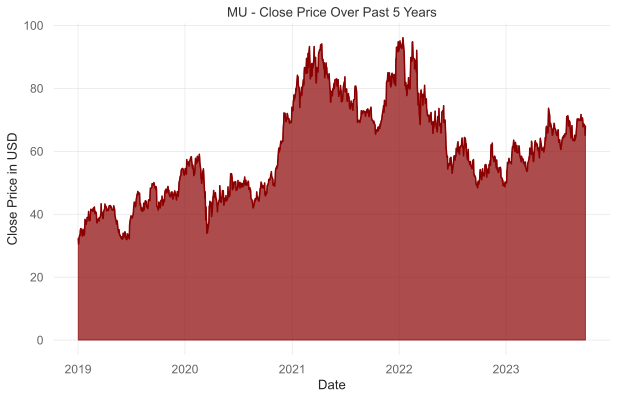

In [3]:
# Daily close price data for MU
plt.fill_between(mu_data.index, mu_data['Close'], color='darkred', alpha=0.7)
plt.plot(mu_data.index, mu_data['Close'], color='darkred', label='Close Price Line')
plt.xlabel('Date')
plt.ylabel('Close Price in USD')
plt.title('MU - Close Price Over Past 5 Years')
plt.grid(True)
plt.show()

## 2. Calculate returns, expected mean returns and risk

In [4]:
# Asset Returns/Rate of Returns: the cumulative daily rate of return is useful to determine /
#                                   the value of an investment at regular intervals.
data_close = mu_data[['Close']]
data_close.columns = ['MU']

returns = np.log(data_close / data_close.shift(1))
returns = returns.dropna()

# Expected Mean Returns
mean_returns = returns.mean()

# Volatility: market volatility is defined as the standard deviation of prices/returns.
vol = returns.std()

# Gain-Loss Ratio (GLR) represents the relative relationship of trades with a positive /
#                                       return and trades with a negative return
glr = returns[returns['MU'] > 0].sum() / returns[returns['MU'] < 0].sum().abs()

# Sharpe Ratio (SR) is the amount of excess return over the risk-free rate as the relevant measure of risk.
## rf is daily risk free rate.
# rf = (1.02 ** (1 / 360)) - 1

risk_free_rate = 0
sr = (mean_returns - risk_free_rate) / vol

# Compound Annual Growth Rate (CAGR)
cumulative_returns = returns.cumsum()
num_trading_days = len(returns)
cagr = (cumulative_returns['MU'][-1]) ** (252/num_trading_days) - 1

# Variance
var = returns.var() * 252

# CVAR
cvar = returns[returns <= np.percentile(returns, 5)].mean() * 252

# See metrics in table format
data_summary = pd.DataFrame({
    'Mean Returns': mean_returns,
    'Volatility': vol,
    'Gain-Loss Ratio (GLR)': glr,
    'Sharpe Ratio (SR)': sr,
    'CAGR': cagr,
    'Variance': var,
    'CVAR': cvar
})

data_summary


C:\Users\Admin\AppData\Local\Temp\ipykernel_10584\1702605445.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = (cumulative_returns['MU'][-1]) ** (252/num_trading_days) - 1


,Mean Returns,Volatility,Gain-Loss Ratio (GLR),Sharpe Ratio (SR),CAGR,Variance,CVAR
MU,0.000624,0.029188,1.059818,0.02138,-0.060209,0.214685,-16.05826


## 3. Define statistical trading strategy (at least one, maximum 2)

In [5]:
# Exponential moving average (EMA) strategy
def ema_strategy(data, small, large):
    signals = pd.DataFrame(data)

    # EMA for 20 and 100-day windows
    signals['ema_short'] = signals['Close'].ewm(span = small, adjust = False).mean()
    signals['ema_long'] = signals['Close'].ewm(span = large, adjust = False).mean()
                         
    # Define a crossover strategy
    signals['bullish'] = 0.0
    signals['bullish'] = np.where(signals['ema_short'] > signals['ema_long'], 1, 0)
    signals['crossover'] = signals['bullish'].diff()

    # Calculate passive and strategy's returns
    signals['returns'] = np.log(signals['Close'] / signals['Close'].shift(1))
    signals['strategy'] = signals['bullish'].shift(1) * signals['returns']
    
    return signals

C:\Users\Admin\AppData\Local\Temp\ipykernel_10584\3536721409.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(ema_strat['ema_long'][idx], 'ro', markersize = 3, color='#000000')
C:\Users\Admin\AppData\Local\Temp\ipykernel_10584\3536721409.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(ema_strat['ema_long'][idx], 'ro', markersize = 3, color='#000000')


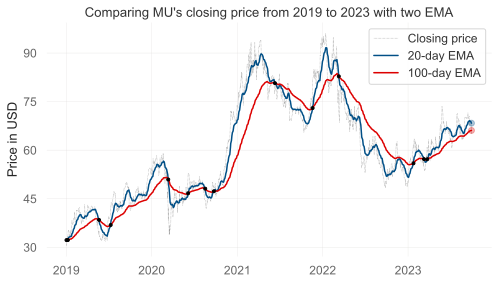

In [6]:
# Initiate strategy
ema_strat = ema_strategy(mu_data, 20, 100)

# Plot exponential moving averages for our strategy
# fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ema_strat['Close'], label='Closing price', color='grey', linestyle=':', linewidth=0.5)
ax.plot(ema_strat['ema_short'], label='20-day EMA', color='#014f86')
ax.plot(ema_strat.index[-1], ema_strat['ema_short'].iloc[-1], 'o', markersize=6, alpha=0.3, color='#014f86')
ax.plot(ema_strat['ema_long'], label='100-day EMA', color='#DC0000')
ax.plot(ema_strat.index[-1], ema_strat['ema_long'].iloc[-1], 'o', markersize=6, alpha=0.3, color='#DC0000')

# Plot crossovers
idx = np.argwhere(ema_strat['crossover']).flatten()
ax.plot(ema_strat['ema_long'][idx], 'ro', markersize = 3, color='#000000')

# Add Legend and Labels
ax.legend(loc='best')

# Prettify

## Create the grid 
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

## Reformat y-axis
ax.set_ylabel('Price in USD')
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

## Remove the spines
ax.spines[['top','right','bottom']].set_visible(False)

## Make the left spine thicker
ax.spines['left'].set_linewidth(1.1)
# Add in title and subtitle
ax.set_title(label="Comparing MU's closing price from 2019 to 2023 with two EMA")
## Adjust the margins around the plot area
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

# Show the plot
plt.show()

<Axes: title={'center': 'Strategy Positioning'}, xlabel='Date'>

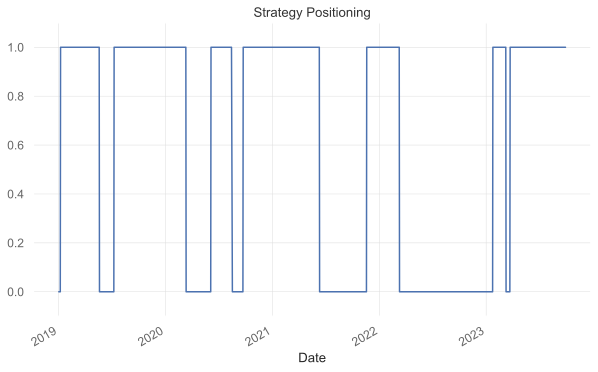

In [7]:
# Plot our strategy's positions
ema_strat['bullish'].plot(ylim=[-0.1, 1.1],
title='Strategy Positioning',
figsize=(10, 6))

returns     187.767570
strategy     29.788866
dtype: float64

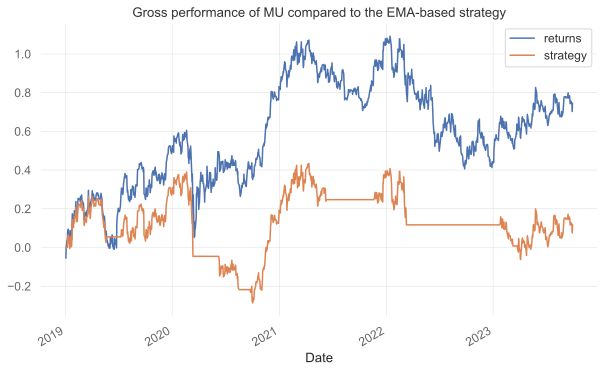

In [8]:
# Plot our strategy's returns compared to MU's stock performance
ema_strat[['returns', 'strategy']].cumsum().plot(figsize=(10, 6), 
                                                         title="Gross performance of MU compared to the EMA-based strategy")

ema_strat[['returns', 'strategy']].sum() * 252

## 4. Evaluate the efficacy of the trading strategy

In [42]:
qs.reports.metrics(ema_strat['strategy'])

                    Strategy
------------------  ----------
Start Period        2019-01-03
End Period          2023-09-29
Risk-Free Rate      0.0%
Time in Market      61.0%

Cumulative Return   -14.63%
CAGR﹪              -2.28%

Sharpe              0.07
Prob. Sharpe Ratio  56.32%
Sortino             0.1
Sortino/√2          0.07
Omega               1.02

Max Drawdown        -51.57%
Longest DD Days     1318

Gain/Pain Ratio     0.02
Gain/Pain (1M)      0.08

Payoff Ratio        0.98
Profit Factor       1.02
Common Sense Ratio  1.01
CPC Index           0.51
Tail Ratio          0.99
Outlier Win Ratio   6.5
Outlier Loss Ratio  2.64

MTD                 -3.04%
3M                  0.22%
6M                  11.14%
YTD                 -4.11%
1Y                  -4.11%
3Y (ann.)           4.68%
5Y (ann.)           -2.28%
10Y (ann.)          -2.28%
All-time (ann.)     -2.28%

Avg. Drawdown       -12.18%
Avg. Drawdown Days  170
Recovery Factor     0.23
Ulcer Index         0.29
Serenity Index      

In [44]:
# Calculate Annualized Volatility
from math import sqrt
vol = ema_strat['strategy'].std() * sqrt(252)
vol

0.3407537085285213

## 5. Training a Deep Q-learning model in stock trading

In [10]:
# Import libraries for environment and model
from gym_anytrading.envs import StocksEnv, Actions, Positions
from stable_baselines3 import DQN

In [27]:
# Create a gym_anytrading environment using MU's stock data
env = gym.make('stocks-v0',
    df = pd.DataFrame(mu_data['Close']),
    window_size = 10,
    frame_bound = (10, len(mu_data)),
)

In [12]:
# Create a DQN model and set parameters
model = DQN("MlpPolicy",
            env = env,
            buffer_size = 5000, #number of old observation steps saved ### podem aumentar 10000 ou 20000
            learning_starts = 200, # memory warmup ## podem aumentar 500, 1000
            train_freq = 1, # prediction network gets an update each train_freq's step ### aqui podem alterar 1,2,3,4
            batch_size = 4, # mini batch size drawn at each update step ### 8,16,32
            policy_kwargs = {'net_arch': [50,50]}, # hidden layer size of MLP ### podem alterar camadas e neurónios por camada: [100], [10,20],[50,100]
            exploration_fraction = 0.1, # Fraction of training steps the epsilon decays ### alterar aqui; 0.05, ou 0.2 
            target_update_interval = 100, # Target network gets updated each target_update_interval's step
            gamma = 0.9,
            verbose = 1, # verbosity of stable-basline's prints
            tau = 1e-4, ### fazer com 1e-5  (leva mais tempo),
            seed = 2023
            )

simulation_time = 5
tau = 1e-4
nb_steps = int(simulation_time // tau)

# Initiate learning
#model.learn(total_timesteps= nb_steps, log_interval=4)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [28]:
# Save learned model as a zip file
# model.save("dqn_mu")

# Load saved model (zip file)
model = DQN.load("dqn_mu")

In [29]:
# Reset environment to its initial state
observation, info = env.reset(seed=2023)

# Initiate dictionary to store action counts
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

# Loop to apply the trained model on the environment
while True:
    action, _states = model.predict(observation, deterministic = True)
    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        print("info:", info)
        print("action_stats:", action_stats)
        break

env.close()

info: {'total_reward': 44.5806770324707, 'total_profit': 1.6324755760951246, 'position': <Positions.Long: 1>}
action_stats: {<Actions.Sell: 0>: 23, <Actions.Buy: 1>: 1161}


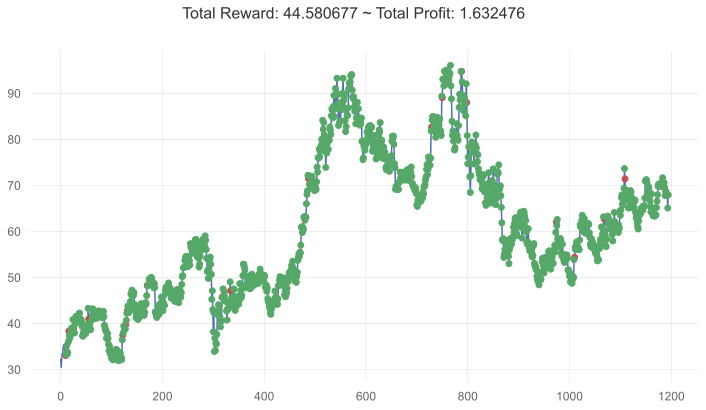

In [30]:
# Plot results
plt.figure(figsize=(12, 6))
env.unwrapped.render_all()
plt.show()

## 6. Evaluate the efficacy of the RL strategy

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

                           Strategy
-------------------------  ----------
Start Period               2019-01-03
End Period                 2023-09-14
Risk-Free Rate             0.0%
Time in Market             3.0%

Cumulative Return          63.25%
CAGR﹪                     7.47%

Sharpe                     0.52
Prob. Sharpe Ratio         87.4%
Smart Sharpe               0.52
Sortino                    0.83
Smart Sortino              0.83
Sortino/√2                 0.59
Smart Sortino/√2           0.59
Omega                      1.84

Max Drawdown               -38.05%
Longest DD Days            577
Volatility (ann.)          26.96%
Calmar                     0.2
Skew                       1.96
Kurtosis                   137.81

Expected Daily %           0.04%
Expected Monthly %         0.86%
Expected Yearly %          10.3%
Kelly Criterion            32.3%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.74%
Expected Shortfall (cVaR)  -2.74%

Max Consecutive Wins       1


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-02-15,2022-12-19,2023-09-14,577,-38.054523,-32.187542
2,2020-03-23,2020-04-15,2020-10-30,222,-21.855221,-20.614754
3,2019-06-12,2019-06-12,2019-08-19,69,-11.637953,-8.853883


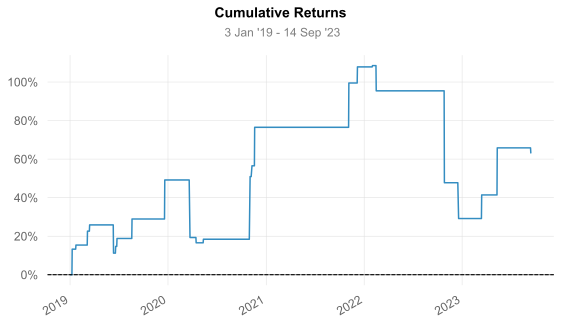

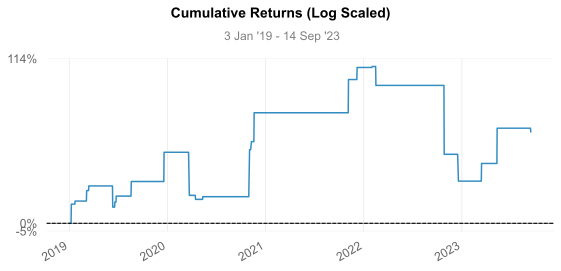

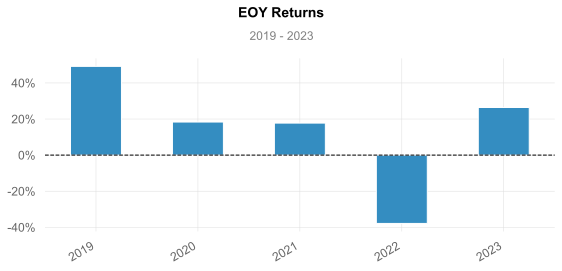

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

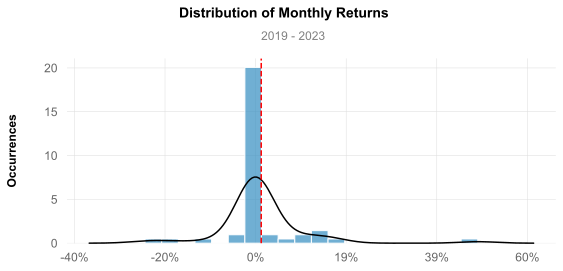

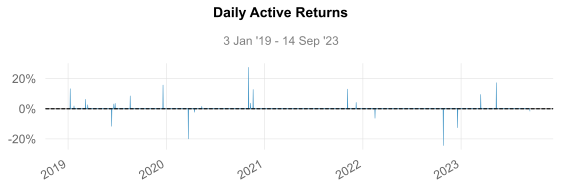

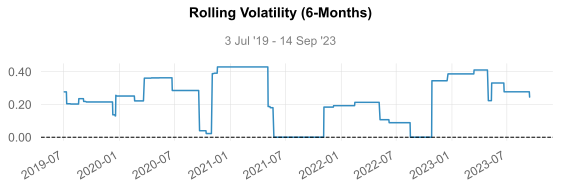

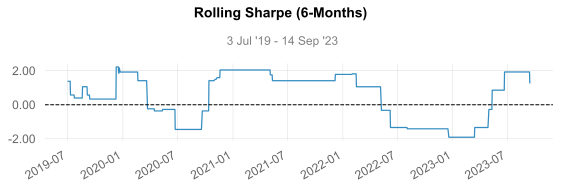

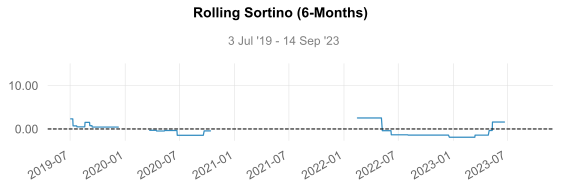

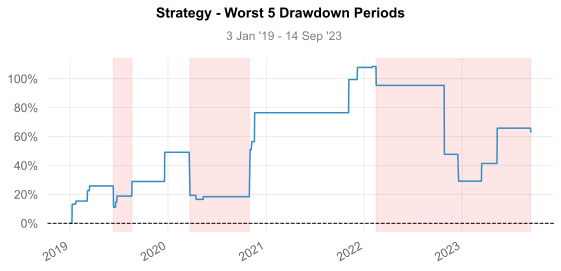

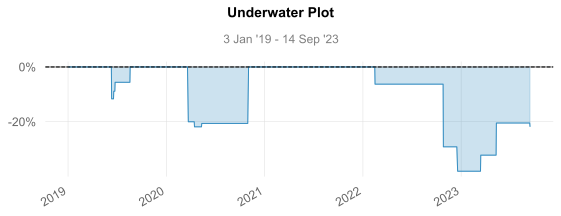

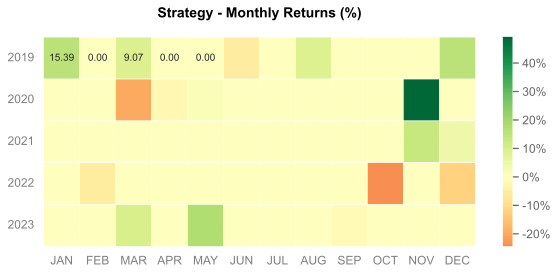

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

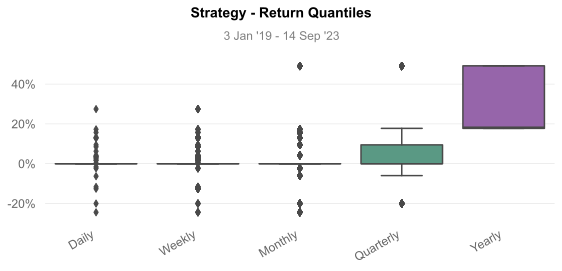

In [31]:
# Calculate metrics and visualize plots for the DeepQ-Learning strategy
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=mu_data.index[0:1184])
rl_returns = net_worth.pct_change().iloc[1:]

rl_returns = rl_returns.tz_localize(None)

qs.reports.full(rl_returns)

## 7. Fine-tune your algorithms

### 7.1. Optimizing the Exponential Moving Averages parameters

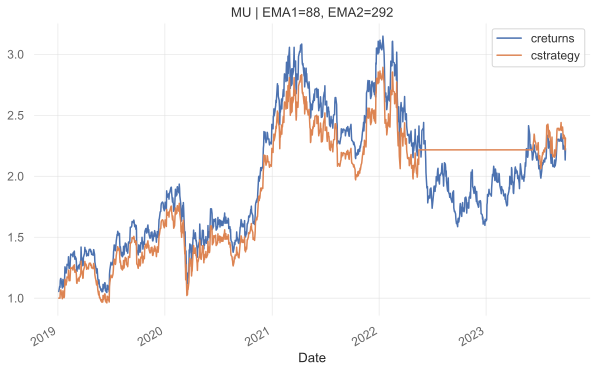

In [17]:
# Optimizing EMA strategy
import ema
ema_opt = ema.EMA('MU', 40, 20, "2019-01-01", "2023-09-30")

ema_opt.optimize_parameters((10, 100, 2), (100, 400, 2))

ema_opt.plot_results()

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the 

                           Strategy
-------------------------  ----------
Start Period               2019-01-03
End Period                 2023-09-29
Risk-Free Rate             0.0%
Time in Market             78.0%

Cumulative Return          53.6%
CAGR﹪                     6.45%

Sharpe                     0.43
Prob. Sharpe Ratio         82.26%
Smart Sharpe               0.38
Sortino                    0.61
Smart Sortino              0.54
Sortino/√2                 0.43
Smart Sortino/√2           0.38
Omega                      1.09

Max Drawdown               -46.06%
Longest DD Days            942
Volatility (ann.)          41.37%
Calmar                     0.14
Skew                       -0.38
Kurtosis                   7.07

Expected Daily %           0.04%
Expected Monthly %         0.76%
Expected Yearly %          8.96%
Kelly Criterion            4.29%
Risk of Ruin               0.0%
Daily Value-at-Risk        -4.22%
Expected Shortfall (cVaR)  -4.22%

Max Consecutive Wins       1

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-20,2020-03-16,2020-12-03,288,-46.059148,-43.609481
2,2021-03-02,2022-04-27,2023-09-29,942,-36.552628,-34.508689
3,2019-03-22,2019-06-17,2019-07-18,119,-27.538130,-27.129605
4,2019-09-18,2019-10-02,2019-12-13,87,-18.125555,-17.499061
5,2019-07-25,2019-08-09,2019-09-04,42,-13.871931,-13.345555


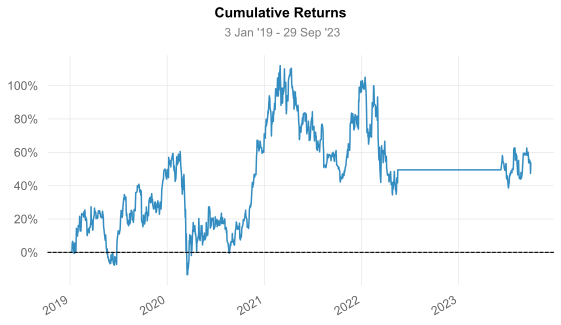

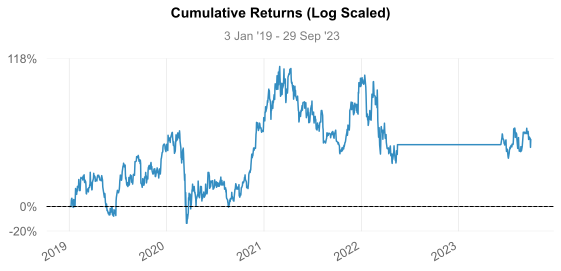

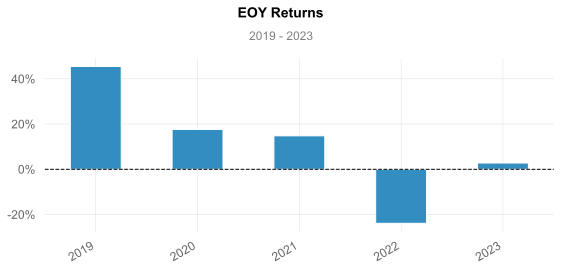

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

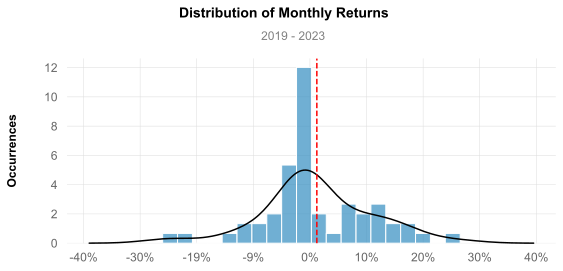

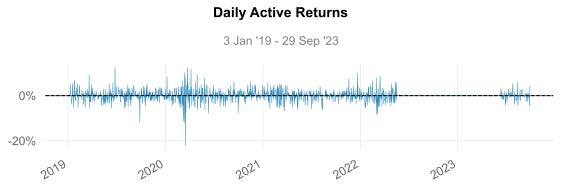

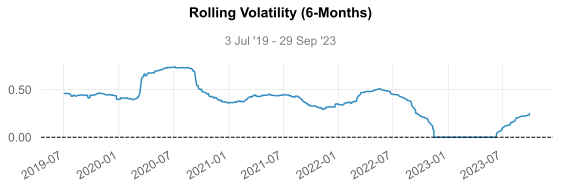

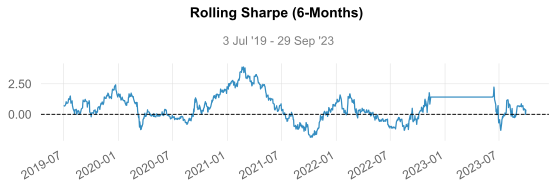

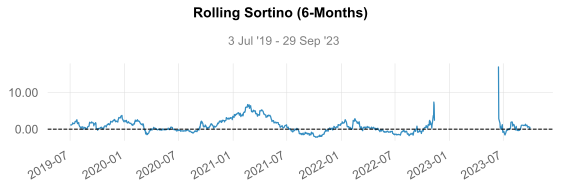

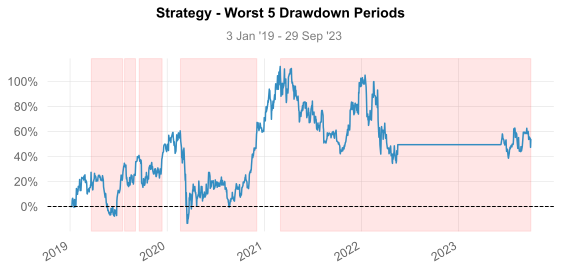

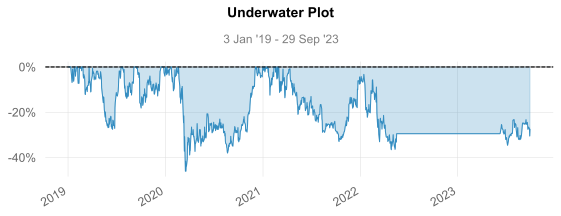

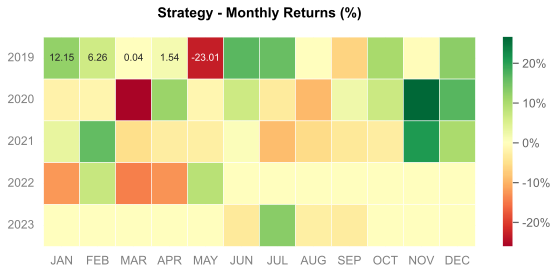

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

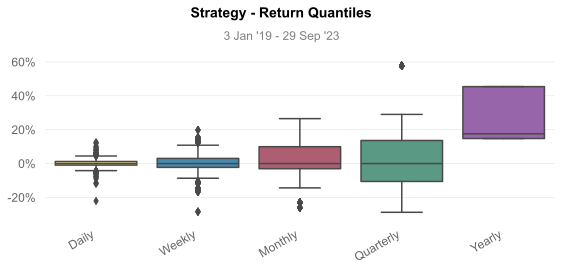

In [41]:
# Evaluatin Optimized EMA

ema_optz = ema_strategy(mu_data, 88, 292)
ema_optz = ema_optz['strategy'].tz_localize(None)
qs.reports.full(ema_optz)

### 7.2. Hyperparameter tuning for RL strategy

In [18]:
# Define hyperparameters ranges
buffer_sizes = [5000, 20000]
learning_start_values = [200, 1000]
train_freq_values = [1, 4]
batch_sizes = [4, 32]
policy_kwargs_options = [{'net_arch': [50]}, {'net_arch': [50, 100]}]
exploration_fractions = [0.05, 0.2]
gammas = [0.8, 0.95]
learning_rates = [0.1, 0.0001]

# Generate all combinations
all_combinations = list(itertools.product(
    buffer_sizes,
    learning_start_values,
    train_freq_values,
    batch_sizes,
    policy_kwargs_options,
    exploration_fractions,
    gammas,
    learning_rates 
))

simulation_time = 5
tau = 1e-4
nb_steps = int(simulation_time // tau)

In [19]:
# Define the total number of combinations for the progress bar
total_combinations = len(all_combinations)
total_combinations

256

In [20]:
# Define evaluation functions that return performance metrics for the model
def get_profit(model):
    # Reset environment to its initial state
    observation, info = env.reset(seed=2023)

    # Initiate dictionary to store action counts
    action_stats = {Actions.Sell: 0, Actions.Buy: 0}

    # Loop to apply the trained model on the environment
    while True:
        action, _states = model.predict(observation, deterministic = True)
        action_stats[Actions(action)] += 1
        observation, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
           return info["total_profit"]

def get_reward(model):
    # Reset environment to its initial state
    observation, info = env.reset(seed=2023)

    # Initiate dictionary to store action counts
    action_stats = {Actions.Sell: 0, Actions.Buy: 0}

    # Loop to apply the trained model on the environment
    while True:
        action, _states = model.predict(observation, deterministic = True)
        action_stats[Actions(action)] += 1
        observation, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
           return info["total_reward"]

In [ ]:
# Create a progress bar
progress_bar = tqdm(total=total_combinations, desc='Grid Search Progress', position=0, leave=True)

# Create dataframe to store results
results = pd.DataFrame(columns=["Parameters", "Total Reward", "Total Profit"])

# Grid Search
for combination in all_combinations:
    (buffer_size, learning_starts, train_freq, batch_size, policy_kwargs, exploration_fraction, gamma, learning_rate) = combination

    # Define the model
    model = DQN("MlpPolicy", env, buffer_size=buffer_size, learning_starts=learning_starts,
                train_freq=train_freq, batch_size=batch_size, gamma=gamma, policy_kwargs=policy_kwargs,
                exploration_fraction=exploration_fraction, learning_rate=learning_rate, target_update_interval=100,
                tau = 1e-4, verbose=0, seed = 2023)

    # Train the model
    model.learn(total_timesteps=nb_steps)

    # Evaluate the model
    reward = get_reward(model)
    profit = get_profit(model)
    
    if profit > 1.5:
        # Clean combination of parameters
        combination_strings = [str(item).replace('{', '').replace('}', '').replace('[', '').replace(']', '').replace(':', '').replace("'", '').replace(" ", "") for item in combination]
        result_string = '_'.join(combination_strings)
        
        # Save learned model as a zip file
        model.save(result_string)

    # Store results
    new_entry = {
    "Parameters": combination,
    "Total Reward": reward,  # Replace with your actual value
    "Total Profit": profit   # Replace with your actual value
    }
    
    # Append the new entry to the DataFrame
    results = pd.concat([results, pd.DataFrame([new_entry])], ignore_index=True)
    
    # Update the progress bar
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

In [ ]:
# Grid Search Progress: 100%|██████████| 256/256 [5:09:47<00:00, 72.61s/it]   
# Best Hyperparameters: (20000, 1000, 1, 4, {'net_arch': [50]}, 0.05, 0.8, 0.0001)
# Best Performance: 2.0355084443366347

In [ ]:
# Load optimized model
model = DQN.load("/saved_models/20000_200_4_4_net_arch50,100_0.2_0.8_0.0001")

In [ ]:
# Reset environment to its initial state
observation, info = env.reset(seed=2023)

# Initiate dictionary to store action counts
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

# Loop to apply the trained model on the environment
while True:
    action, _states = model.predict(observation, deterministic = True)
    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        print("info:", info)
        print("action_stats:", action_stats)
        break

env.close()

# Plot results
plt.figure(figsize=(12, 6))
env.unwrapped.render_all()
plt.show()

## 8. Compare and interpret the results

### 8.1. Compare between non-optimized and optimized EMA strategy

In [ ]:
# Normal EMA
ema_norm = ema_strat['strategy'].tz_localize(None)
# Optimized EMA
ema_optz = ema_strategy(mu_data, 88, 292)
ema_optz = ema_optz['strategy'].tz_localize(None)

qs.reports.metrics(ema_optz, ema_norm)

### 8.2. Compare between optimized EMA strategy and optimized RL strategy

In [ ]:
# Calculate metrics and visualize plots
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=mu_data.index[0:1184])
rl_returns = net_worth.pct_change().iloc[1:]

rl_returns = rl_returns.tz_localize(None)

qs.reports.full(rl_returns, ema_optz)